In [1]:
import os
from os.path import abspath, dirname
import shutil as sh
from io import StringIO
from icecream import ic
import fitz

from PIL import Image
from PIL import ImageFilter

from matplotlib import pyplot as plt 
import pytesseract
import numpy as np
import cv2
import pandas as pd
from collections import defaultdict
import statistics

## Image extraction from PDF 

In [139]:
def extract_img(file_name, save_img):
    sh.rmtree(save_img)  # delete this folder
    # if file don't exist, then create
    try:
        os.makedirs(save_img)
    except:
        print ("Directory already exist.")

    img_count = 0
    file_name1, _ = os.path.splitext(file_name)
    absolute_path = os.path.join(folder_path, file_name)

    doc = fitz.open(absolute_path)  # Document('.pdf')
    lenXREF = doc.xref_length()  # the number of entries in the xref table (cross-reference number)
    print(f'file name: {file_name}, the number of pages: {len(doc)}, length of xref table: {lenXREF - 1}')

    # extract images from each pages
    for idx, page in enumerate(doc): 
        imgs_list = page.get_images()  # the number of images in each page  
        for i in imgs_list:
            single_img = list(i)  # tuple -> list          
            xref = single_img[0]   
            img = doc.extract_image(xref)  # get image info

            # delete too small images, that may not be a chart
            pix = fitz.Pixmap(doc, xref)
            if pix.size < 10000: continue 
            img_count += 1

            # add images into folder
            img_name = f'{img_count}_p{idx+1}.' + img["ext"]  
            img_name = file_name1 + "_" + img_name
            img_path = os.path.join(save_img, img_name)   
            
            img_out = open(img_path, 'wb')   
            img_out.write(img["image"])   
            img_out.close

    print(f'Extraction finished. Total images: {img_count}')


file_name = 'sample5.pdf'
folder_path = abspath(dirname(file_name))  # get the direction
save_img = folder_path + '/imagesss'

extract_img(file_name, save_img)

file name: sample5.pdf, the number of pages: 54, length of xref table: 1326
Extraction finished. Total images: 4


## Line chart

### No image preprocessing

In [25]:
filename = 'line_chart_color3.jpeg'
img1 = np.array(Image.open(filename))

# Get verbose data including boxes, confidences, line and page numbers
data = pytesseract.image_to_data(Image.open(filename))

df = pd.read_csv(StringIO(data), sep='\t')
df = df.dropna().reset_index().drop(labels='index', axis=1)
df = df[~df['text'].isin([' ','  ','   '])]
df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,5,1,1,1,1,1,97,538,20,22,92.998070,%
1,5,1,1,1,1,2,95,505,22,23,96.529892,of
2,5,1,1,1,1,3,95,428,28,70,96.529892,youth
3,5,1,1,1,1,4,102,390,15,29,96.682526,on
4,5,1,1,1,1,5,95,337,22,43,96.682526,this
5,5,1,1,1,1,6,95,222,28,105,96.695084,platform
6,5,1,2,1,1,1,160,125,49,19,95.753479,80%
7,5,1,3,1,1,1,160,253,49,19,96.250877,60%
8,5,1,4,1,1,1,159,379,50,19,94.772659,40%
9,5,1,5,1,1,1,160,505,49,19,95.823189,20%


In [273]:
# title lies on the top-most of the chart in most cases
# title = df[df.top == df.top.min()].text.values
title = df[df.top == sorted(set(df.top.values))[2]].text.values
title = ' '.join(title)
ic(title)

# y label lies on the left-most of the chart in most cases, adjacent to y-axis
y_label = df[df.left == df.left.min()].text.values
y_label = ' '.join(y_label)
y_axis = df[df.left == sorted(set(df.left.values))[2]].text.values
ic(y_label, y_axis)

# x label lies on the bottom-most of the chart in most cases, adjacent to x-axis
x_label = df[df.top == df.top.max()].text.values
y_label = ' '.join(x_label)
x_axis = df[df.top == sorted(set(df.top.values))[-2]].text.values
ic(x_label, x_axis)

ic| title: 'Number of officers in Crime'
ic| y_label: 'Chart Number of police officers'
    y_axis: array(['404'], dtype=object)
ic| x_label: array(['Year'], dtype=object)
    x_axis: array(['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
                   '2019'], dtype=object)


(array(['Year'], dtype=object),
 array(['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
        '2019'], dtype=object))

### Applying image preprocessing (sometimes result is better)

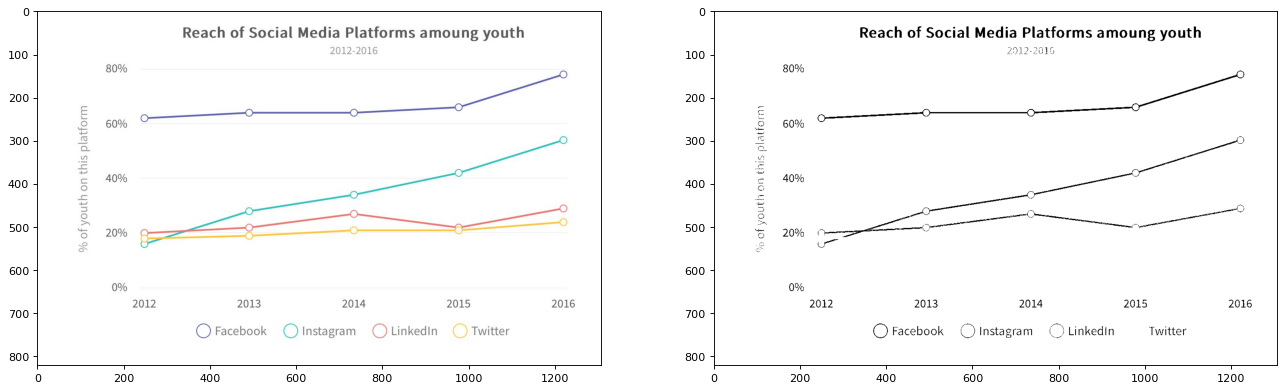

In [2]:
# eliminate noise
def img_preprocessing(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    norm_img = np.zeros((image.shape[0], image.shape[1]))
    image = cv2.normalize(image, norm_img, 0, 255, cv2.NORM_MINMAX)
    image = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY)[1]  # > threshold 120, set it to maxval 255 white, otherwise 0 black
    image = cv2.GaussianBlur(image, (1, 1), 0)  # Gaussian Smoothing
    return image


# using PIL show image
def Image_show(original_img, image):
    img_cvt1 = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    img_cvt1 = Image.fromarray(img_cvt1)
    img_cvt2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_cvt2 = Image.fromarray(img_cvt2)

    figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
    ax[0].imshow(img_cvt1)
    ax[1].imshow(img_cvt2)


# using cv2 show image
def cv2_show(name, img):
    cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

original_img = cv2.imread('line_chart_color3.jpeg')

img = img_preprocessing(original_img)
Image_show(original_img, img)

Sharpening image

Text(0.5, 1.0, 'Kernel2')

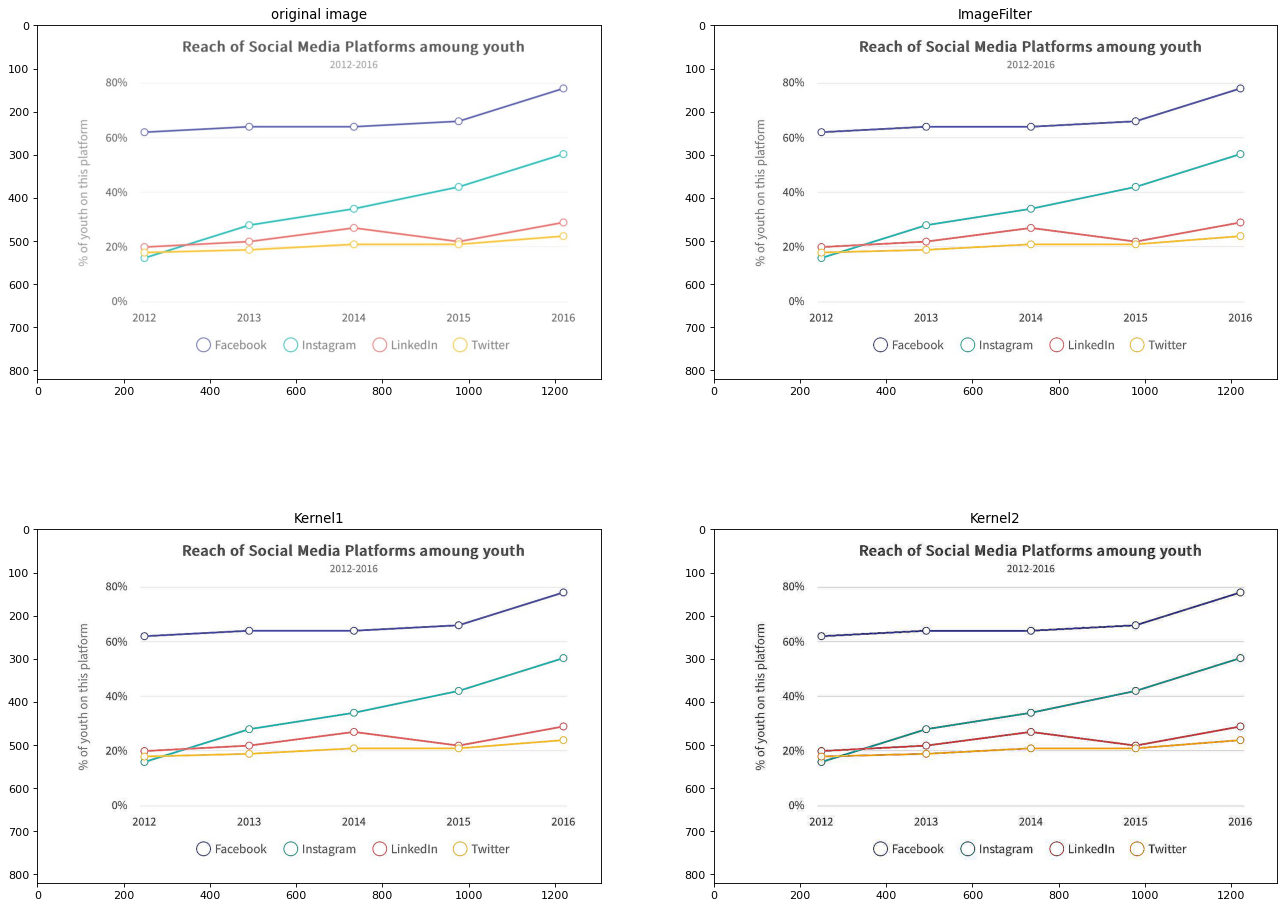

In [66]:
def cv2_PIL(original_img):
    img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    return img
img1 = cv2_PIL(original_img)
img2 = img1.filter(ImageFilter.SHARPEN)
img2 = img2.filter(ImageFilter.SHARPEN)


def kernel_PIL(original_img, kernel):
    img = cv2.filter2D(original_img, -1, kernel)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    return img
kernel1 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  
kernel2 = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img3 = kernel_PIL(original_img, kernel1)
img4 = kernel_PIL(original_img, kernel2)


figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15), dpi=80)
ax[0][0].imshow(img1)
ax[0][0].set_title('original image')
ax[0][1].imshow(img2)
ax[0][1].set_title('ImageFilter')
ax[1][0].imshow(img3)
ax[1][0].set_title('Kernel1')
ax[1][1].imshow(img4)
ax[1][1].set_title('Kernel2')

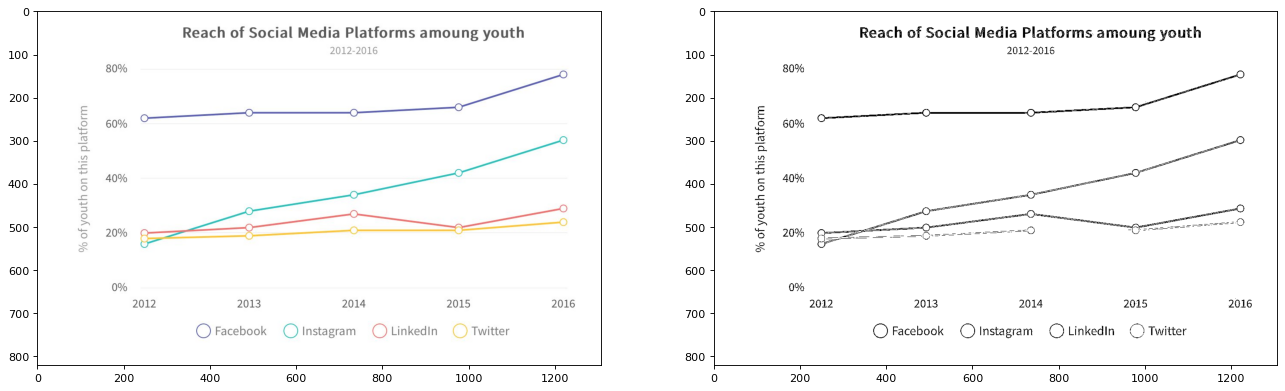

In [67]:
img = cv2.cvtColor(np.array(img4), cv2.COLOR_RGB2BGR)
img = img_preprocessing(img)
Image_show(original_img, img)

## Extracting coordinate system info

Using pytesseract libray to extract text

In [ ]:
# def text_extraction(img_pre, original_img, if_img_pre):
#     if if_img_pre: 
#         img_rgb = cv2.cvtColor(img_pre, cv2.COLOR_BGR2RGB)  
#     else:
#         img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  

#     data = pytesseract.image_to_data(img_rgb)

#     # convert to dataframe and delete nan values and blank spaces
#     df = pd.read_csv(StringIO(data), sep='\t')
#     df = df.dropna().reset_index().drop(labels='index', axis=1)
#     df = df[~df['text'].isin([' ','  ','   '])]

#     return df


# df = text_extraction(img, original_img, False)
# df

In [71]:
img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # after image processing the effect becomes worse
# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # after image processing the effect becomes worse
# data = pytesseract.image_to_data(img4)
data = pytesseract.image_to_data(img_rgb)

# convert to dataframe and delete nan values and blank spaces
df = pd.read_csv(StringIO(data), sep='\t')
df = df.dropna().reset_index().drop(labels='index', axis=1)
df = df[~df['text'].isin([' ','  ','   '])]
df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,5,1,1,1,1,1,97,537,20,23,93.028801,%
1,5,1,1,1,1,2,95,505,22,23,96.649391,of
2,5,1,1,1,1,3,95,428,28,70,96.649391,youth
3,5,1,1,1,1,4,102,390,15,28,96.128609,on
4,5,1,1,1,1,5,95,337,22,43,96.128609,this
5,5,1,1,1,1,6,95,222,27,105,96.838188,platform
6,5,1,2,1,1,1,160,125,49,19,95.108818,80%
7,5,1,3,1,1,1,160,253,49,19,96.002296,60%
8,5,1,4,1,1,1,159,379,50,19,94.056366,40%
9,5,1,5,1,1,1,160,505,49,19,94.381462,20%


In [4]:
# title lies on the top-most of the chart in most cases
title = df[df.top == df.top.min()].text.values
# title = df[df.top == sorted(set(df.top.values))[2]].text.values
title = ' '.join(title)
ic(title)


# y label lies on the left-most of the chart in most cases, adjacent to y-axis
y_label = df[df.left == df.left.min()].text.values
y_label = ' '.join(y_label)

y_set_point = sorted(set(df.left.values))[3]
# y_axis = df[df.left == set_point].text.values
y_df = df[df.left.between(y_set_point-1, y_set_point+20)]
y_axis = y_df.text.values
# y_axis = list(map(lambda x: int(x), y_axis))  # str -> int 
y_top_pixel = y_df.top.values
y_h_pixel = y_df.height.values
ic(y_label, y_axis, y_top_pixel, y_h_pixel)  # 0 was not recognized


# x label lies on the bottom-most of the chart in most cases, adjacent to x-axis
# x_label = df[df.top == df.top.max()].text.values
# x_label = ' '.join(x_label)

# x_df = df[df.top == sorted(set(df.top.values))[-2]]
x_set_point = sorted(set(df.top.values))[-5]
x_df = df[df.top.between(x_set_point-1, x_set_point+1)]
x_axis = x_df.text.values
x_left_pixel = x_df.left.values 
x_w_pixel = x_df.width.values 
# ic(x_label, x_axis, x_left_pixel, x_w_pixel)
ic(x_axis, x_left_pixel, x_w_pixel)

ic| title: 'Reach of Social Media Platforms youth'
ic| y_label: 'of youth this platform'
    y_axis: array(['80%', '60%', '40%', '20%', '0%'], dtype=object)
    y_top_pixel: array([125, 253, 379, 505, 631])
    y_h_pixel: array([19, 19, 19, 19, 19])
ic| x_axis: array(['2012', '2013', '2014', '2015', '2016'], dtype=object)
    x_left_pixel: array([ 222,  464,  708,  950, 1193])
    x_w_pixel: array([53, 54, 53, 54, 53])


(array(['2012', '2013', '2014', '2015', '2016'], dtype=object),
 array([ 222,  464,  708,  950, 1193]),
 array([53, 54, 53, 54, 53]))

In [325]:
# legend
legend_set_point = sorted(set(df.top.values))[-2]
legend_df = df[df.top.between(legend_set_point-1, legend_set_point+1)]
legend = legend_df.text.values
legend_left_pixel = legend_df.left.values 
legend_w_pixel = legend_df.width.values 
legend_top_pixel = legend_df.top.values 
legend_h_pixel = legend_df.height.values 
ic(legend, legend_left_pixel, legend_w_pixel, legend_top_pixel, legend_h_pixel)

ic| legend_axis: array(['Facebook', 'Instagram', 'Linkedin', 'Twitter'], dtype=object)
    legend_left_pixel: array([ 415,  617,  823, 1007])
    legend_w_pixel: array([117, 121, 104,  88])


(array(['Facebook', 'Instagram', 'Linkedin', 'Twitter'], dtype=object),
 array([ 415,  617,  823, 1007]),
 array([117, 121, 104,  88]))

find real x and y piexel value

x_real_pixel = x_left_pixel + x_w_pixel / 2

y_real_pixel = y_top_pixel + y_h_pixel / 2

In [5]:
x_real_pixel = x_left_pixel + x_w_pixel / 2
y_real_pixel = y_top_pixel + y_h_pixel / 2
ic(x_real_pixel, y_real_pixel)

ic| x_real_pixel: array([ 248.5,  491. ,  734.5,  977. , 1219.5])
    y_real_pixel: array([134.5, 262.5, 388.5, 514.5, 640.5])


(array([ 248.5,  491. ,  734.5,  977. , 1219.5]),
 array([134.5, 262.5, 388.5, 514.5, 640.5]))

If incorrectly recognized or if some are not recognized, below correct it.

In [6]:
y_pixel_max = y_real_pixel[-1]
ic(x_axis, y_axis, y_real_pixel, y_pixel_max)

ic| x_axis: array(['2012', '2013', '2014', '2015', '2016'], dtype=object)
    y_axis: array(['80%', '60%', '40%', '20%', '0%'], dtype=object)
    y_real_pixel: array([134.5, 262.5, 388.5, 514.5, 640.5])
    y_pixel_max: 640.5


(array(['2012', '2013', '2014', '2015', '2016'], dtype=object),
 array(['80%', '60%', '40%', '20%', '0%'], dtype=object),
 array([134.5, 262.5, 388.5, 514.5, 640.5]),
 640.5)

## Color isolation

Because the values of pixels B, G and R are correlated with the light falling on the object, these values are also correlated with each other and cannot accurately describe the pixel. In contrast, in HSV space, the three are relatively independent and can exactly describe the hue, saturation and value of a pixel.

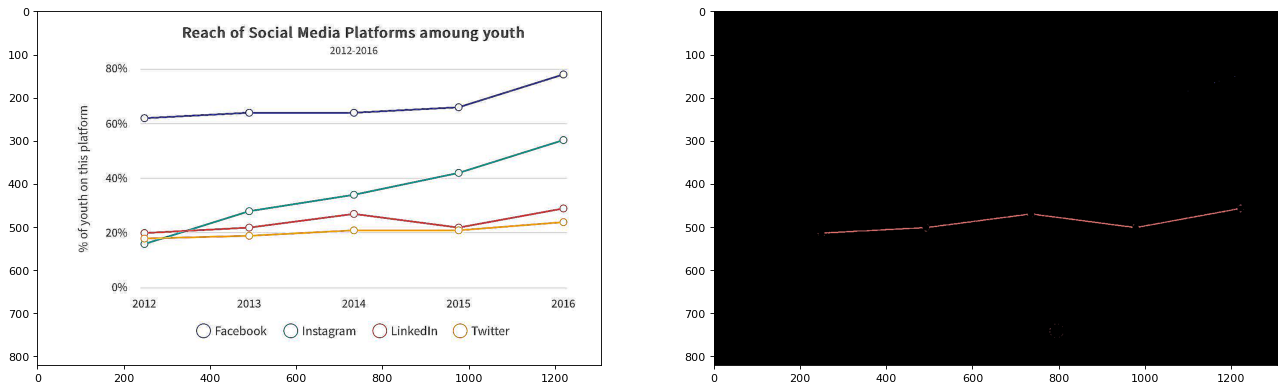

In [24]:
def color_separation(original_img, lowerb, upperb):
    # convert to HSV
    img_hsv = cv2.cvtColor(original_img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(img_hsv, lowerb, upperb)
    # separate color with mask
    img_masked = cv2.bitwise_and(original_img, original_img, mask=mask)
    return img_masked

red_lowerb = np.array([110,110,190])  # very clear: 110,50,50
red_upperb = np.array([210,220,250])  # very clear: 230,200,190
yellow_lowerb = np.array([90,150,220])
yellow_upperb = np.array([200,255,255])
# blue_lowerb = np.array([170,170,90])
# blue_upperb = np.array([240,240,180])

blue_lowerb = np.array([100,150,0])  # ?
blue_upperb = np.array([140,255,255])

# purple_lowerb = np.array([170,90,90])
# purple_upperb = np.array([230,200,190])
purple_lowerb = np.array([130, 30, 30])
purple_upperb = np.array([255, 255, 255])

img_red = color_separation(original_img, red_lowerb, red_upperb)
# img_red = color_separation(original_img, blue_lowerb, blue_upperb)
# img_red = color_separation(original_img, yellow_lowerb, yellow_upperb)

Image_show(original_img, img_red)
# Image_show(img, img_red)


### Canny Edge Detection

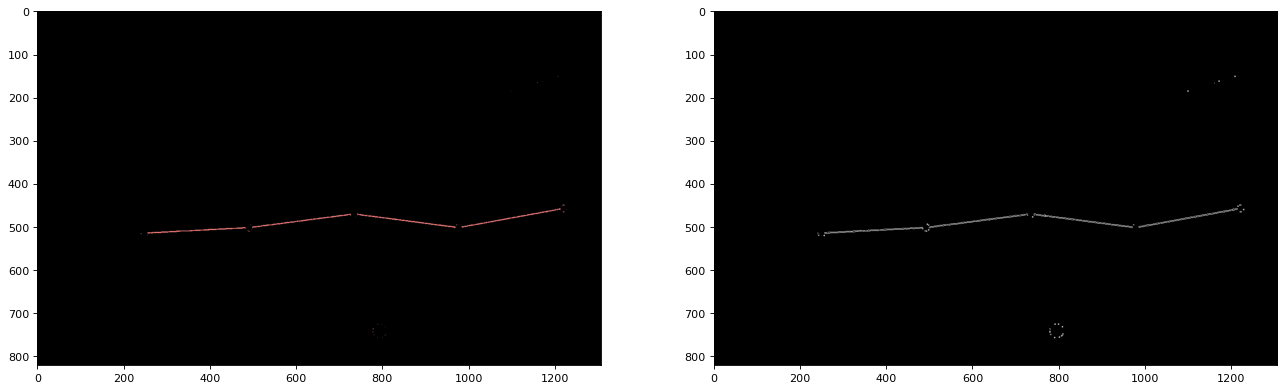

In [26]:
def find_contour(image):
# gray= cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(image, 50, 200)
    # _, edges = cv2.threshold(gray, 150, 200, cv2.THRESH_BINARY)  # apply binary thresholding
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return edges, contours

edges, contours = find_contour(img_red)
Image_show(img_red, edges)

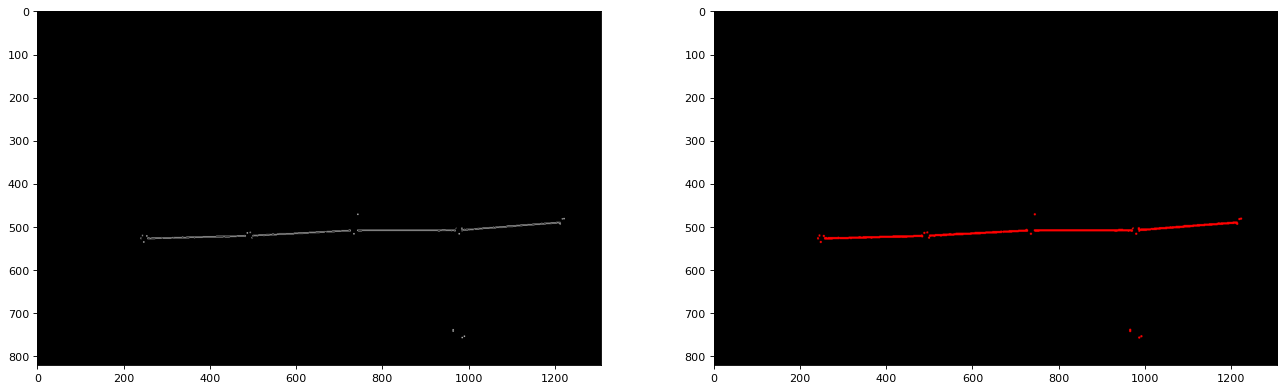

In [16]:
# draw the red contours
tmp = cv2.drawContours(img_red, contours, -1, (0,0,255), 2)  
Image_show(edges, tmp)

## Calculate real y-axis value based on proportion

### Finding legend

In [ ]:
# legend_top_pixel
# legend_h_pixel
legend_lower = max(set(legend_top_pixel.tolist()), key=legend_top_pixel.tolist().count)
legend_upper = legend_top_pixel + legend_h_pixel
legend_upper = max(set(legend_upper.tolist()), key=legend_top_pixel.tolist().count)
ic(legend_lower, legend_upper)

### Discrete output value of y

In [331]:
def discrete(tolerance):
    y_dic = defaultdict(list)
    for i in contours:
        for j in i:
            if j[0][0] in x_real_pixel and y_real_pixel[0] <= j[0][1] <= y_real_pixel[-1]:
                y_dic[j[0][0]].append(j[0][1])
    x_y_value = sorted(y_dic.items(), key=lambda x:x[0])

    exist_value = []
    for i in x_y_value:
        exist_value.append(i[0])

    missing_value = []
    for i in x_real_pixel:
        if i not in exist_value:
            missing_value.append(i)

    missing_value_dic = defaultdict(list)
    for i in contours:
        for j in i:
            for m in missing_value:
                if m-tolerance <= j[0][0] <= m+tolerance and y_real_pixel[0] <= j[0][1] <= y_real_pixel[-1]:
                    missing_value_dic[j[0][0]].append(j[0][1])
                    missing_value.remove(m)  # make sure only add one value
                    if len(missing_value) == 0:
                        break

    y_dic.update(missing_value_dic)
    x_y_value = sorted(y_dic.items(), key=lambda x:x[0])

    return x_y_value


tolerance = 1
x_y_value = discrete(tolerance)

In [17]:
# x correspond to y pixel value
y_dic = defaultdict(list)
for i in contours:
    for j in i:
        if j[0][0] in x_real_pixel and y_real_pixel[0] <= j[0][1] <= y_real_pixel[-1]:
            y_dic[j[0][0]].append(j[0][1])

x_y_value = sorted(y_dic.items(), key=lambda x:x[0])
x_y_value

[(977, [516, 517, 518])]

y axis value of the other month cannot be recognized.

In [358]:
ic(x_real_pixel, y_real_pixel)

ic| x_real_pixel: array([ 248.5,  491. ,  734.5,  977. , 1219.5])
    y_real_pixel: array([134.5, 262.5, 388.5, 514.5, 640.5])


(array([ 248.5,  491. ,  734.5,  977. , 1219.5]),
 array([134.5, 262.5, 388.5, 514.5, 640.5]))

In [359]:
exist_value = []
for i in x_y_value:
    exist_value.append(i[0])

missing_value = []
for i in x_real_pixel:
    if i not in exist_value:
        missing_value.append(i)
missing_value

[248.5, 734.5, 977.0, 1219.5]

Using the adjacent x-axis value to find y-axis value

In [360]:
tolerance = 6

missing_value_dic = defaultdict(list)
for i in contours:
    for j in i:
        for m in missing_value:
            if m-tolerance <= j[0][0] <= m+tolerance and y_real_pixel[0] <= j[0][1] <= y_real_pixel[-1]:
                missing_value_dic[j[0][0]].append(j[0][1])
                missing_value.remove(m)  # make sure only add one value
                if len(missing_value) == 0:
                    break

# x_y_value = sorted(y_dic.items(), key=lambda x:x[0])
# x_y_value
missing_value_dic

defaultdict(list, {254: [520], 972: [495], 737: [477], 1218: [467]})

In [361]:
y_dic.update(missing_value_dic)
x_y_value = sorted(y_dic.items(), key=lambda x:x[0])
x_y_value

[(254, [520]),
 (491, [510, 512, 512, 510]),
 (737, [477]),
 (972, [495]),
 (1218, [467])]

In [362]:
x_y_value_mean = [statistics.mean(i[1]) for i in x_y_value]

# img_w, img_l = original_img.shape[0], original_img.shape[1]
y_pixel_min = y_real_pixel[0]
# y_axis_max = int(y_axis[0])
y_axis_max = float(y_axis[0].strip('%')) / 100.0 
ic(x_y_value_mean, y_pixel_min, y_axis_max)

ic| x_y_value_mean: [520, 511, 477, 495, 467]
    y_pixel_min: 134.5
    y_axis_max: 0.8


([520, 511, 477, 495, 467], 134.5, 0.8)

y = (y_pixel_max - x_y_value) / (y_pixel_max - y_pixel_min) * y_axis_max


In [363]:
y_axis_value = []
for i in x_y_value_mean:
    y = (y_pixel_max - i) / (y_pixel_max - y_pixel_min) * y_axis_max
    y = round(y, 4)
    y_axis_value.append(y)
y_axis_value

[0.1905, 0.2047, 0.2585, 0.23, 0.2743]

In [364]:
# data = pd.DataFrame(y_label:y_axis_value, columns=x_axis)
data = pd.DataFrame(index=range(1), columns=x_axis)
data.iloc[0:] = y_axis_value
data

,2012,2013,2014,2015,2016
0,0.1905,0.2047,0.2585,0.23,0.2743


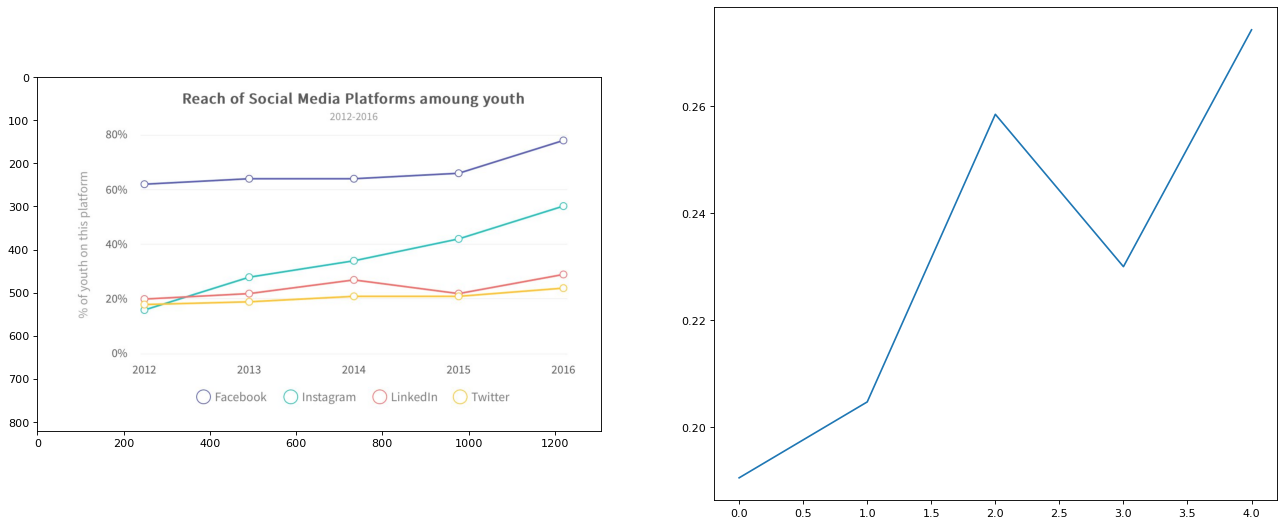

In [365]:
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
ax[1].plot(y_axis_value)

### Continuous output value of y

In [27]:
# x correspond to y pixel value
y_dic = defaultdict(list)
for i in contours:
    for j in i:
        if x_real_pixel[0] <= j[0][0] <= x_real_pixel[-1] and y_real_pixel[0] <= j[0][1] <= y_real_pixel[-1]:
            y_dic[j[0][0]].append(j[0][1])

x_y_value = sorted(y_dic.items(), key=lambda x:x[0])
x_y_value

[(254, [520, 521, 522]),
 (255, [522, 520]),
 (256, [522, 521, 520, 515, 514, 515, 516]),
 (257, [516, 514, 514, 516]),
 (258, [516, 514, 514, 516]),
 (259, [516, 514, 514, 516]),
 (260, [516, 514, 514, 516]),
 (261, [516, 514, 516]),
 (262, [516, 516]),
 (263, [513, 516, 516]),
 (264, [514, 514, 516, 516]),
 (265, [513, 513, 516, 516]),
 (266, [513, 513, 516, 516]),
 (267, [513, 513, 516, 516]),
 (268, [513, 513, 516, 516]),
 (269, [513, 513, 515, 515]),
 (270, [513, 513, 515, 515]),
 (271, [513, 513, 515, 515]),
 (272, [513, 513, 515, 515]),
 (273, [513, 513, 515, 515]),
 (274, [513, 513, 515, 515]),
 (275, [513, 513, 515, 515]),
 (276, [513, 513, 515, 515]),
 (277, [513, 513, 515, 515]),
 (278, [513, 513, 515, 515]),
 (279, [513, 513, 515, 515]),
 (280, [513, 513, 515, 515]),
 (281, [513, 513, 515, 515]),
 (282, [513, 513, 515, 515]),
 (283, [513, 513, 515, 515]),
 (284, [513, 513, 515, 515]),
 (285, [513, 513, 515, 515]),
 (286, [513, 513, 515, 515]),
 (287, [512, 512, 515, 515]),


In [28]:
x_y_value_mean = []
x_axis_con = []
for i in x_y_value:
    x, y = i
    # y_mean = statistics.mean(y)
    y_mean = np.mean(y)
    # y_mean = max(set(y),key=y.count)

    x_y_value_mean.append(y_mean)
    x_axis_con.append(x)

In [29]:
# img_w, img_l = original_img.shape[0], original_img.shape[1]
y_pixel_min = y_real_pixel[0]
# y_axis_max = int(y_axis[0])
y_axis_max = float(y_axis[0].strip('%')) / 100.0 
y_axis_max

0.8

In [30]:
y_axis_value = []
for i in x_y_value_mean:
    y = (y_pixel_max - i) / (y_pixel_max - y_pixel_min) * y_axis_max
    # y = round(y, 2)
    y = round(y, 6)
    y_axis_value.append(y)
y_axis_value

[0.188933,
 0.188933,
 0.194353,
 0.198419,
 0.198419,
 0.198419,
 0.198419,
 0.197892,
 0.196838,
 0.198419,
 0.198419,
 0.199209,
 0.199209,
 0.199209,
 0.199209,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.200791,
 0.200791,
 0.201581,
 0.201581,
 0.201581,
 0.201581,
 0.201581,
 0.201581,
 0.201581,
 0.201581,
 0.201581,
 0.201581,
 0.201581,
 0.201581,
 0.201581,
 0.201581,
 0.201581,
 0.201581,
 0.202635,
 0.203162,
 0.203162,
 0.203162,
 0.203162,
 0.203162,
 0.203162,
 0.203162,
 0.203162,
 0.203162,
 0.203162,
 0.203162,
 0.203162,
 0.203162,
 0.203162,
 0.203162,
 0.203162,
 0.203953,
 0.203953,
 0.203953,
 0.203953,
 0.203953,
 0.204743,
 0.204743,
 0.204743,
 0.204743,
 0.204743,
 0.204743,
 0.204743,
 0.204743,
 0.206324,
 0.206324,
 0.206324,
 0.206324,
 0.206324,
 0.206324,
 0.206324,
 0.206324,
 0.206324,
 0.206324,
 0.20527,
 0.205059,
 0.206008,
 0.206324,
 0.206324,
 0.205797,
 0.204743,
 0.204743,
 0

(0.0, 1.0)

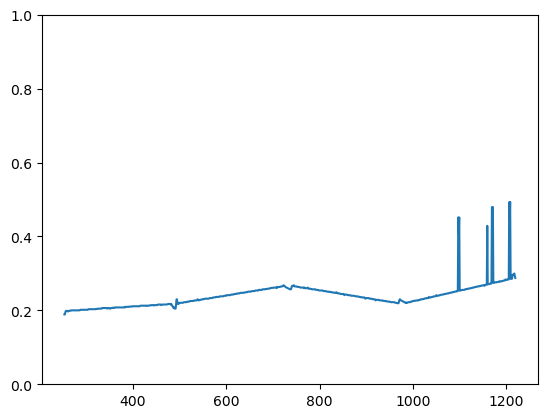

In [31]:
plt.plot(x_axis_con, y_axis_value)
plt.ylim(0,1)

In [299]:
# data = pd.DataFrame(y_label:y_axis_value, columns=x_axis)
data = pd.DataFrame(index=range(1), columns=x_axis_con)
data.iloc[0:] = y_axis_value
data

,254,255,256,257,258,259,260,261,262,263,...,1209,1210,1211,1212,1213,1214,1215,1217,1218,1219
0,0.188933,0.188933,0.194353,0.198419,0.198419,0.198419,0.198419,0.197892,0.196838,0.198419,...,0.285375,0.286166,0.285375,0.285827,0.296443,0.296443,0.295652,0.299605,0.2917,0.287747


change time

In [300]:
# change time
def x_axis_change(x_axis_con, x_real_pixel, x_axis):
    x_axis_con_t = []
    for i, m in enumerate(x_axis_con):
        if x_real_pixel[0] <= m < x_real_pixel[1]:
            time = x_axis[0] + '_' + str(m)
        elif x_real_pixel[1] <= m < x_real_pixel[2]:
            time = x_axis[1] + '_' + str(m)
        elif x_real_pixel[2] <= m < x_real_pixel[3]:
            time = x_axis[2] + '_' + str(m)
        elif x_real_pixel[3] <= m < x_real_pixel[4]:
            time = x_axis[3] + '_' + str(m)
        else:
            time = x_axis[4] + '_' + str(m)
        x_axis_con_t.append(time) 

    return x_axis_con_t

x_axis_con_t = x_axis_change(x_axis_con, x_real_pixel, x_axis)

In [301]:
data = pd.DataFrame(index=range(1), columns=x_axis_con_t)
data.iloc[0:] = y_axis_value
data

,2012_254,2012_255,2012_256,2012_257,2012_258,2012_259,2012_260,2012_261,2012_262,2012_263,...,2015_1209,2015_1210,2015_1211,2015_1212,2015_1213,2015_1214,2015_1215,2015_1217,2015_1218,2015_1219
0,0.188933,0.188933,0.194353,0.198419,0.198419,0.198419,0.198419,0.197892,0.196838,0.198419,...,0.285375,0.286166,0.285375,0.285827,0.296443,0.296443,0.295652,0.299605,0.2917,0.287747


## Deleting unusual value (or outliers)

### Standard Deviation Method

In [302]:
# calculate summary statistics
data_mean, data_std = np.mean(y_axis_value), np.std(y_axis_value)

# identify outliers
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off

# identify outliers
outliers = [x for x in y_axis_value if x < lower or x > upper]
# remove outliers
outliers_removed = [x for x in y_axis_value if x >= lower and x <= upper]
ic(len(outliers), len(outliers_removed))

ic| len(outliers): 10, len(outliers_removed): 931


(10, 931)

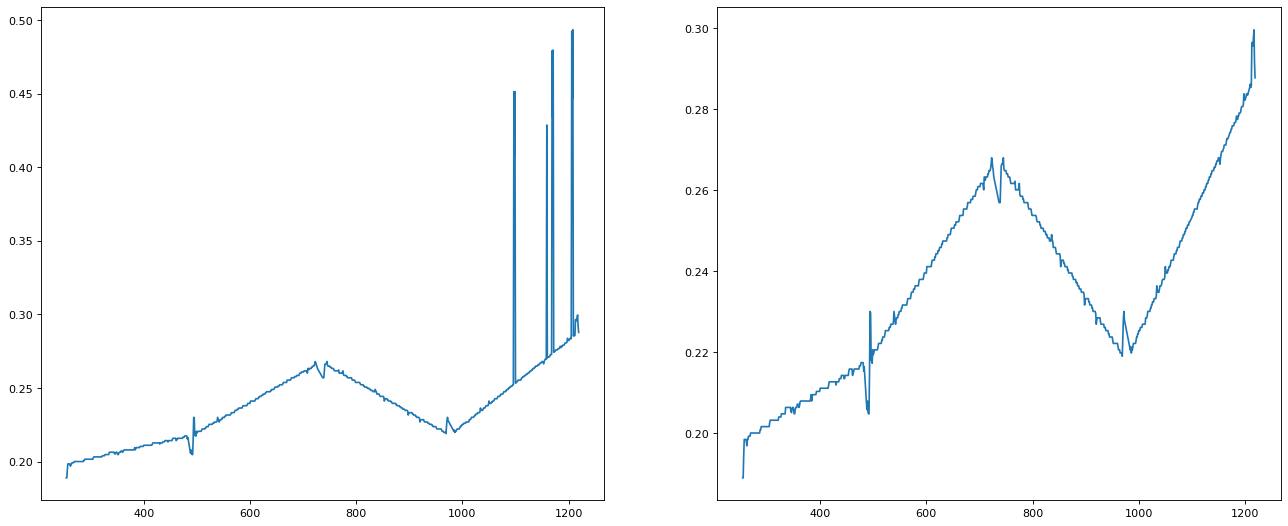

In [303]:
dat = {'time': x_axis_con, 'yellow':y_axis_value}
data = pd.DataFrame(dat)

df_outliers_removed = data[data.yellow.isin(outliers_removed)]
x_outliers_removed = df_outliers_removed.time.values
y_outliers_removed = df_outliers_removed.yellow.values

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].plot(x_axis_con, y_axis_value)
ax[1].plot(x_outliers_removed, y_outliers_removed)

### Interquartile Range Method

In [304]:
# calculate interquartile range
q25, q75 = np.percentile(y_axis_value, 25), np.percentile(y_axis_value, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

# calculate the outlier cutoff
cut_off = iqr *1.5
lower, upper = q25 - cut_off, q75 + cut_off

# identify outliers
outliers = [x for x in y_axis_value if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in y_axis_value if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=0.217, 75th=0.255, IQR=0.037
Identified outliers: 10
Non-outlier observations: 931


In [306]:
def iqr(y_axis_value):
    # calculate interquartile range
    q25, q75 = np.percentile(y_axis_value, 25), np.percentile(y_axis_value, 75)
    iqr = q75 - q25
    # print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    # identify outliers
    outliers = [x for x in y_axis_value if x < lower or x > upper]
    # print('Identified outliers: %d' % len(outliers))
    # remove outliers
    outliers_removed = [x for x in y_axis_value if x >= lower and x <= upper]
    # print('Non-outlier observations: %d' % len(outliers_removed))

    return outliers_removed

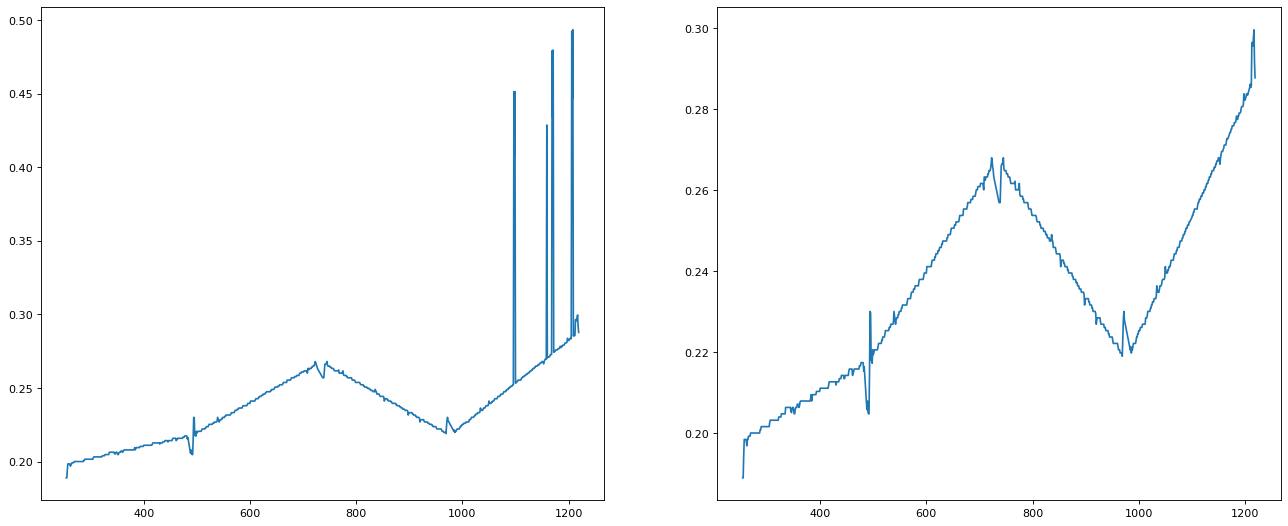

In [307]:
dat = {'time': x_axis_con, 'yellow':y_axis_value}
data = pd.DataFrame(dat)

df_outliers_removed = data[data.yellow.isin(outliers_removed)]
x_outliers_removed = df_outliers_removed.time.values
y_outliers_removed = df_outliers_removed.yellow.values

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].plot(x_axis_con, y_axis_value)
ax[1].plot(x_outliers_removed, y_outliers_removed)

### Sliding window

In [309]:
outliers_removed = []
len_window = 40
for i in range((len(y_axis_value) // len_window) + 1):
    window_outliers_removed = iqr(y_axis_value[len_window*i : len_window*(i+1)])
    outliers_removed.append(window_outliers_removed)

ic(len(outliers_removed))
outliers_removed = [item for sub_list in outliers_removed for item in sub_list]
ic(len(outliers_removed))

ic| len(outliers_removed): 24
ic| len(outliers_removed): 918


918

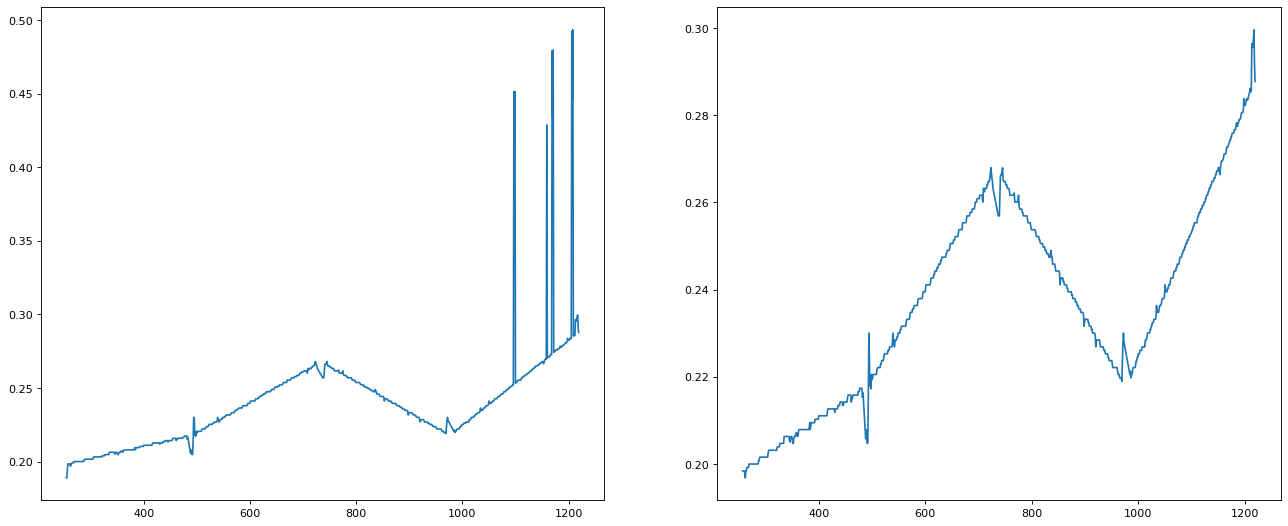

In [310]:
df_outliers_removed = data[data.yellow.isin(outliers_removed)]
x_outliers_removed = df_outliers_removed.time.values
y_outliers_removed = df_outliers_removed.yellow.values

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].plot(x_axis_con, y_axis_value)
ax[1].plot(x_outliers_removed, y_outliers_removed)